In [1]:
from scripts import dataset
from scripts.tools import *
from models import Xception
from sklearn import metrics
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

set_GPU('0')

In [2]:
dataset_path = '/path/to/Glaucoma_processed_K4.pkl'
save_path = '/path/to/save/'

cls_data = dataset.classification(dataset_root=dataset_path, restore=True, workers=1)

tf.reset_default_graph()
net = Xception.create(data_shape=(256,512,1), num_output=2, reduction_ratio=4, enable_SE=True, phase='inference')

saver = tf.train.Saver()
saver.restore(net.sess, save_path+"Xception_highest_auc.ckpt")

In [3]:
pred_orig = []

for batch in cls_data.batch_set['valid']['image']:
    result = net.sess.run(net.logits, feed_dict={net.x : batch[:,:,:,np.newaxis],
                                                 net.is_train: False})
    pred_orig+=list(result)

valid_labels = np.concatenate(cls_data.batch_set['valid']['label'], axis=0)
pred_orig = np.array(pred_orig)

fpr, tpr, _ = metrics.roc_curve(valid_labels, pred_orig[:,1])
tn, fp, fn, tp = metrics.confusion_matrix(valid_labels, pred_orig.argmax(-1)).ravel()

metrics.confusion_matrix(valid_labels, pred_orig.argmax(-1))
auc = metrics.auc(fpr, tpr)
sensitivity = tp / (tp+fn)
specitivity = tn / (tn+fp)
acc = metrics.accuracy_score(valid_labels, pred_orig.argmax(-1))

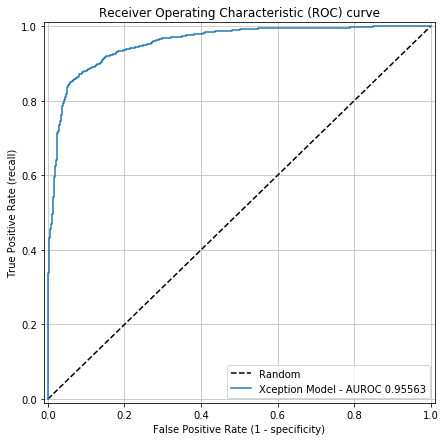

In [4]:
plt.rcParams['figure.figsize'] = (7,7)
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.plot((0,1),(0,1), c='black', linestyle='--')
plt.plot(fpr,tpr)    
plt.legend(['Random', f'Xception Model - AUROC {round(auc,5)}'])
plt.grid(b=True, which='major', c='silver')
plt.show()